In [ ]:
# Need to install:
# pip install git+https://github.com/yeatmanlab/AFQ-Insight.git@upgrade_python_version

In [1]:
import os
import os.path as op
from tempfile import mkdtemp
import glob
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from afqinsight.pipeline import make_base_afq_pipeline

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from afqinsight.datasets import AFQDataset
from afqinsight.augmentation import jitter, time_warp, scaling, magnitude_warp, window_warp
import tempfile
from sklearn.impute import SimpleImputer
from neurocombat_sklearn import CombatModel
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.utils import shuffle, resample
import pandas as pd

import afqinsight.nn.tf_models as nn
import matplotlib.pyplot as plt
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet


/Users/arokem/miniconda3/envs/afqi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not op.exists("participants_updated_id.csv"):
    participants = pd.read_csv("https://fcp-indi.s3.amazonaws.com/data/Projects/HBN/BIDS_curated/derivatives/qsiprep/participants.tsv", sep="\t")
    participants["subject_id_no_prefix"] = participants["subject_id"].str.split("-").str[1]
    participants.to_csv("participants_updated_id.csv", index=False)

In [3]:
if not op.exists("combined_tract_profiles.csv"):
    pd.read_csv("https://fcp-indi.s3.amazonaws.com/data/Projects/HBN/BIDS_curated/derivatives/afq/combined_tract_profiles.csv").to_csv("combined_tract_profiles.csv", index=False)

In [4]:
data_path = "./"

def load_data_notf():
    afq_dataset = AFQDataset.from_files(
        fn_nodes=f"{data_path}combined_tract_profiles.csv",
        fn_subjects=f"{data_path}participants_updated_id.csv",
        dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
        index_col="subject_id",
        target_cols=["age", "dl_qc_score", "scan_site_id"],
        label_encode_cols=["scan_site_id"]
    )
    afq_dataset.drop_target_na()
    qc = afq_dataset.y[:, 1]
    y = afq_dataset.y[:, 0][qc>0]
    site = afq_dataset.y[:, 2][qc>0]
    X = afq_dataset.X[qc>0]
    return X, y, site


In [5]:
X, y, site = load_data_notf()

In [6]:
X_train, X_test, y_train, y_test, site_train, site_test = train_test_split(X, y, site, test_size=0.2)


In [7]:
imputer = SimpleImputer(strategy="median")

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [8]:
combat = CombatModel()


In [9]:
X_train_combat = combat.fit_transform(X_train, site_train[:, None])
X_test_combat = combat.transform(X_test, site_test[:, None])

/Users/arokem/miniconda3/envs/afqi/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
import matplotlib.pyplot as plt

In [11]:
lasso_model = make_base_afq_pipeline(
    feature_transformer=PCA,
    scaler="standard",
    estimator=LassoCV,
    estimator_kwargs={
            "verbose": 0,
            "n_alphas": 50,
            "cv": 3,
            "n_jobs": 28,
            "max_iter": 500}
            )

logistic_model = make_base_afq_pipeline(
    feature_transformer=PCA,
    scaler="standard",
    estimator=LogisticRegressionCV,
    estimator_kwargs={
            "penalty": "l1",
            "verbose": 0,
            "solver": "liblinear",
            "cv": 3,
            "n_jobs": 28,
            "max_iter": 500}
            )

def age_prediction(X_train, y_train, X_test, y_test):
    lasso_model.fit(X_train, y_train)
    score = lasso_model.score(X_test, y_test)
    lasso_model.fit(X_train_combat, y_train)
    score_combat = lasso_model.score(X_test_combat, y_test)
    return score, score_combat

def site_prediction(X_train, X_test, site_train, site_test):
    logistic_model.fit(X_train, site_train.astype(int))
    score = logistic_model.score(X_test, site_test.astype(int))
    logistic_model.fit(X_train_combat, site_train.astype(int))
    score_combat = logistic_model.score(X_test_combat, site_test.astype(int))
    return score, score_combat

In [12]:
scores_combat, scores = [], []
scores_combat_site, scores_site = [], []
for ii in range(10):
    X_train, X_test, y_train, y_test, site_train, site_test = train_test_split(X, y, site, test_size=0.2)
    imputer = SimpleImputer(strategy="median")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    combat = CombatModel()
    X_train_combat = combat.fit_transform(X_train, site_train[:, None])
    X_test_combat = combat.transform(X_test, site_test[:, None])
    score, score_combat = age_prediction(X_train, y_train, X_test, y_test)
    scores.append(score)
    scores_combat.append(score_combat)
    score, score_combat = site_prediction(X_train, X_test, site_train, site_test)
    scores_site.append(score)
    scores_combat_site.append(score_combat)

/Users/arokem/miniconda3/envs/afqi/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/arokem/miniconda3/envs/afqi/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/arokem/miniconda3/envs/afqi/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/arokem/miniconda3/envs/afqi/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

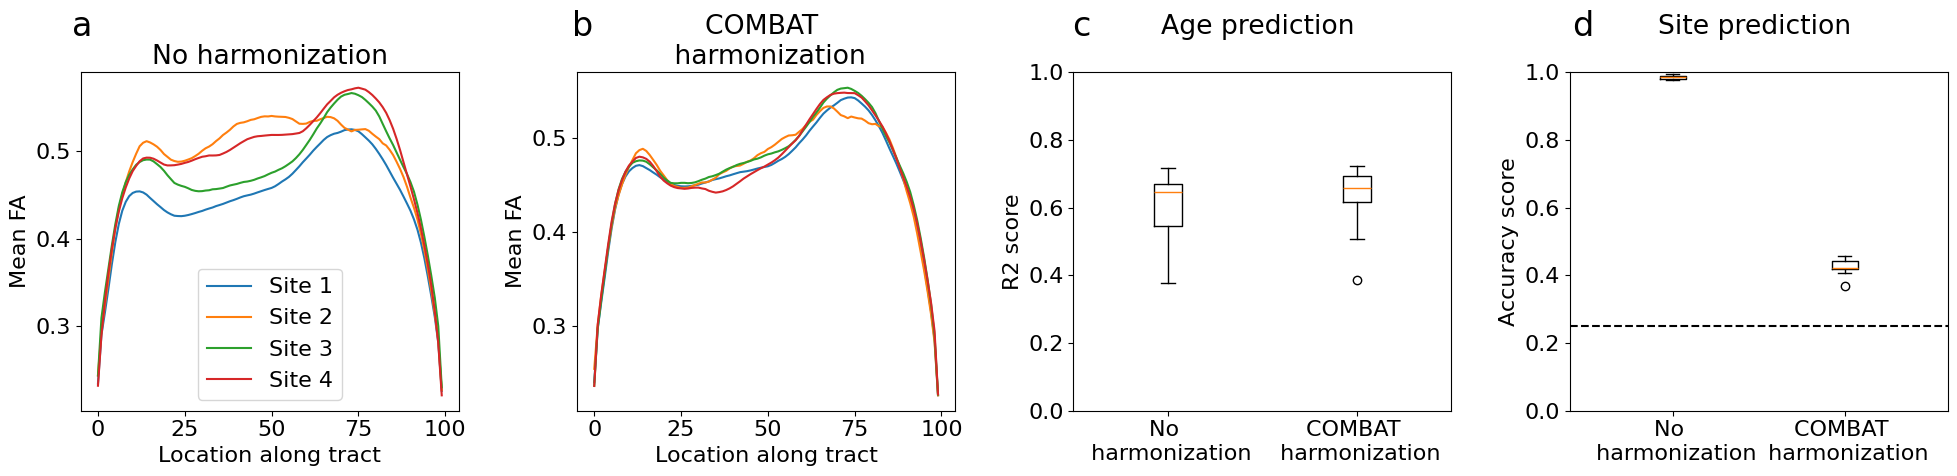

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
plt.rcParams['font.size'] = 16

fig.text(0.05, 0.96, 'a', ha='left', va='top', fontsize=24)
fig.text(0.3, 0.96, 'b', ha='left', va='top', fontsize=24)
fig.text(0.55, 0.96, 'c', ha='left', va='top', fontsize=24)
fig.text(0.8, 0.96, 'd', ha='left', va='top', fontsize=24)

ax[0].set_title("No harmonization")
ax[0].plot(np.array([np.mean(X_test[site_test == site, :100], 0) for site in np.unique(site_test)]).T,
           label=["Site 1", "Site 2", "Site 3", "Site 4"])
ax[0].set_xlabel("Location along tract", fontsize=16)
ax[0].set_ylabel("Mean FA")
ax[0].legend()
ax[1].set_title("COMBAT \n harmonization")
ax[1].plot(np.array([np.mean(X_test_combat[site_test == site, :100], 0) for site in np.unique(site_test)]).T,
           label=["Site 1", "Site 2", "Site 3", "Site 4"])
ax[1].set_xlabel("Location along tract", fontsize=16)
ax[1].set_ylabel("Mean FA")
ax[2].set_title("Age prediction \n")
ax[2].boxplot([scores, scores_combat])
ax[2].set_xticklabels(["No \n harmonization", "COMBAT \n harmonization"], fontsize=16)
ax[2].set_ylabel("R2 score")
ax[2].set_ylim([0, 1])
ax[3].set_title("Site prediction \n")
ax[3].boxplot([scores_site, scores_combat_site])
ax[3].set_xticklabels(["No \n harmonization", "COMBAT \n harmonization"], fontsize=16)
ax[3].set_ylabel("Accuracy score")
ax[3].set_ylim([0, 1])
xlim = ax[3].get_xlim()
ax[3].plot([xlim[0] - 0.1, xlim[1] + 0.1], [0.25, 0.25], "k--")
ax[3].set_xlim([xlim[0] - 0.1, xlim[1] + 0.1])
plt.tight_layout()
